# Read in the data

In [2]:
import pandas as pd
import numpy 
import re
import matplotlib.pyplot as plt 

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

<function matplotlib.pyplot.show>

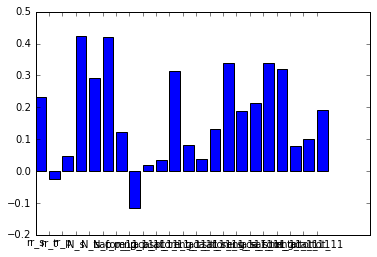

In [22]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
%matplotlib inline
plt.bar(numpy.arange(len(survey_fields)), height = correlations[survey_fields], tick_label =survey_fields)
plt.show

In [23]:
print(correlations[survey_fields][abs(correlations[survey_fields]) > 0.25])

N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_t_11      0.313810
saf_s_11      0.337639
aca_s_11      0.339435
saf_tot_11    0.318753
Name: sat_score, dtype: float64


There is a high correlation between sat score and saf_t_11, saf_s_11 

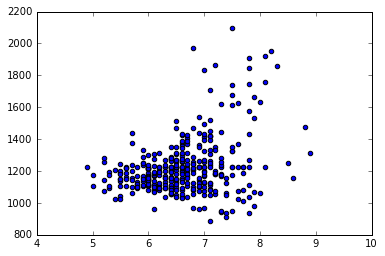

In [24]:
plt.scatter(combined["saf_s_11"], combined["sat_score"])
plt.show()

Schools with high student safety are more likely to score more on SAT

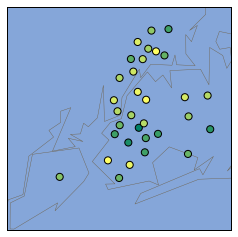

In [29]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace = True)
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s = 50, zorder = 2, latlon = True, c = districts["saf_s_11"], cmap = "summer")
plt.show()

Student safety is high in Manhatten area and low in downtown Brooklyn

In [34]:
print(correlations[["white_per", "asian_per", "black_per", "hispanic_per"]])

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64


White and Asians tend to score more on SAT, while black and hispanics do not

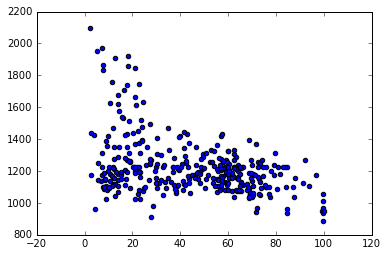

In [35]:
plt.scatter(combined["hispanic_per"], combined["sat_score"])
plt.show()

Schools with high percentage of hispanics are likely to score low

In [36]:
hispanic_schools = combined[combined["hispanic_per"] > 95]
print(hispanic_schools)

        DBN                                        SCHOOL NAME  \
44   02M542                      MANHATTAN BRIDGES HIGH SCHOOL   
82   06M348   WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL   
89   06M552  GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...   
125  09X365                ACADEMY FOR LANGUAGE AND TECHNOLOGY   
141  10X342              INTERNATIONAL SCHOOL FOR LIBERAL ARTS   
176  12X388   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE   
253  19K583                          MULTICULTURAL HIGH SCHOOL   
286  24Q296             PAN AMERICAN INTERNATIONAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
44                      66                            336.0   
82                      70                            380.0   
89                      56                            339.0   
125                     54                            315.0   
141                     49                            300.0   
176                     30 

In [39]:
print(combined.corr()["hispanic_per"])

SAT Critical Reading Avg. Score        -0.401634
SAT Math Avg. Score                    -0.379511
SAT Writing Avg. Score                 -0.389774
sat_score                              -0.396985
AP Test Takers                         -0.220731
Total Exams Taken                      -0.217161
Number of Exams with scores 3 4 or 5   -0.225762
Total Cohort                           -0.190514
CSD                                    -0.386290
NUMBER OF STUDENTS / SEATS FILLED      -0.203866
NUMBER OF SECTIONS                     -0.183194
AVERAGE CLASS SIZE                     -0.225512
SIZE OF SMALLEST CLASS                 -0.130944
SIZE OF LARGEST CLASS                  -0.200651
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                             0.571657
total_enrollment                       -0.204418
ell_num                                 0.170261
ell_percent         

Schools with high hispanic percent have lower SAT.

In [40]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)])

        DBN                                        SCHOOL NAME  \
37   02M475                             STUYVESANT HIGH SCHOOL   
151  10X445                       BRONX HIGH SCHOOL OF SCIENCE   
187  13K430                     BROOKLYN TECHNICAL HIGH SCHOOL   
327  28Q687  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...   
356  31R605                STATEN ISLAND TECHNICAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
37                     832                            679.0   
151                    731                            632.0   
187                   1277                            587.0   
327                    121                            612.0   
356                    227                            635.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
37                 735.0                   682.0     2096.0   
151                688.0                   649.0     1969.0   
187                659.0           

These five schools are ranked as one of the best school in NYC

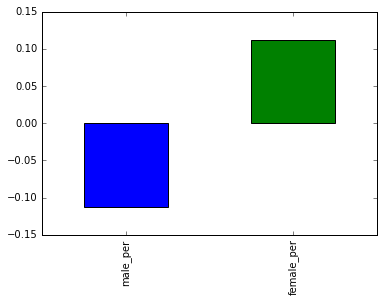

In [43]:
correlations[["male_per", "female_per"]].plot.bar()
plt.show()

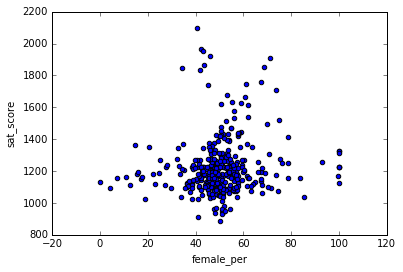

In [44]:
combined.plot.scatter("female_per", "sat_score")
plt.show()

In [45]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)])

        DBN                                        SCHOOL NAME  \
5    01M696                     BARD HIGH SCHOOL EARLY COLLEGE   
26   02M416                      ELEANOR ROOSEVELT HIGH SCHOOL   
60   03M479                                 BEACON HIGH SCHOOL   
61   03M485  FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...   
302  25Q525                        TOWNSEND HARRIS HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
5                      130                            624.0   
26                     127                            572.0   
60                     261                            577.0   
61                     531                            566.0   
302                    278                            621.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
5                  604.0                   628.0     1856.0   
26                 594.0                   592.0     1758.0   
60                 575.0           

In [ ]:
These schools are college-orientated

0.05717081390766967


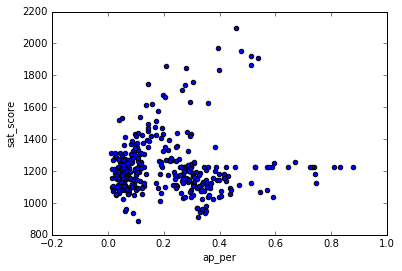

In [47]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter("ap_per", "sat_score")
print(combined.corr()["sat_score"]["ap_per"])

There is no corrolation between AP exams and SAT scores